In [ ]:
import gzip
import json
import pandas as pd
import ast
from ast import literal_eval
import re
import dateutil.parser as dparser
from nltk.sentiment.vader import SentimentIntensityAnalyzer

**steam_games.json.gz**

    Leer el comprimido y crear un CSV

In [ ]:
ruta = '/content/drive/My Drive/Steam_Data/steam_games.json.gz'

# Lista para almacenar los datos JSON procesados
data = []

with gzip.open(ruta, 'rt', encoding='utf-8') as file:
    for line in file:
        try:
            # Cargar el JSON como un diccionario
            obj = json.loads(line.strip())

            # Convertir los valores numéricos en cadenas de caracteres
            for key, value in obj.items():
                if isinstance(value, (int, float)):
                    obj[key] = str(value)

            data.append(obj)
        except json.JSONDecodeError as e:
            print(f"Error al decodificar JSON en línea: {line.strip()}")
            print(str(e))

# Crear un DataFrame a partir de los datos procesados
df = pd.DataFrame(data, dtype=str)

In [ ]:
df

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,id,metascore,developer,user_id,steam_id,items,items_count
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,76561197970982479,76561197970982479,"[{'item_id': '10', 'item_name': 'Counter-Strik...",277.0
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,js41637,76561198035864385,"[{'item_id': '10', 'item_name': 'Counter-Strik...",888.0
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,evcentric,76561198007712555,"[{'item_id': '1200', 'item_name': 'Red Orchest...",137.0
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Riot-Punch,76561197963445855,"[{'item_id': '10', 'item_name': 'Counter-Strik...",328.0
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,doctr,76561198002099482,"[{'item_id': '300', 'item_name': 'Day of Defea...",541.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120440,Ghost_RUS Games,"['Casual', 'Indie', 'Simulation', 'Strategy']",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"['Strategy', 'Indie', 'Casual', 'Simulation']",http://steamcommunity.com/app/773640/reviews/?...,1.49,"['Single-player', 'Steam Achievements']",1.99,False,773640,nan,"Nikita ""Ghost_RUS""",nan,nan,nan,nan
120441,Sacada,"['Casual', 'Indie', 'Strategy']",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"['Strategy', 'Indie', 'Casual']",http://steamcommunity.com/app/733530/reviews/?...,4.24,"['Single-player', 'Steam Achievements', 'Steam...",4.99,False,733530,nan,Sacada,nan,nan,nan,nan
120442,Laush Studio,"['Indie', 'Racing', 'Simulation']",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"['Indie', 'Simulation', 'Racing']",http://steamcommunity.com/app/610660/reviews/?...,1.39,"['Single-player', 'Steam Achievements', 'Steam...",1.99,False,610660,nan,Laush Dmitriy Sergeevich,nan,nan,nan,nan
120443,SIXNAILS,"['Casual', 'Indie']",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"['Indie', 'Casual', 'Puzzle', 'Singleplayer', ...",http://steamcommunity.com/app/658870/reviews/?...,nan,"['Single-player', 'Steam Achievements', 'Steam...",4.99,False,658870,nan,"xropi,stev3ns",nan,nan,nan,nan


In [ ]:
# Crear el nombre del archivo CSV de salida
output_csv = '/content/drive/My Drive/DataOutput_mvp_steam/steam_games.csv'
# Guardar el DataFrame como un archivo CSV con formato str
df.to_csv(output_csv, index=False, float_format='%s')

In [ ]:
steam_games = pd.read_csv('/content/drive/My Drive/DataOutput_mvp_steam/steam_games.csv', dtype=str)

In [ ]:
# Eliminar las primeras 88310 filas
steam_games = steam_games.drop(range(88310))

In [ ]:
steam_games = steam_games.iloc[:, :15]

In [ ]:
# Función para convertir cadenas en listas evitando nan
def safe_literal_eval(x):
    try:
        return literal_eval(x)
    except (ValueError, SyntaxError):
        return []

In [ ]:
steam_games['genres'] = steam_games['genres'].apply(safe_literal_eval)

In [ ]:
# Función para convertir fechas al formato "año/mes/día"
def convertir_fecha(fecha):
    try:
        # Intenta convertir la fecha utilizando dateutil.parser
        fecha_obj = dparser.parse(str(fecha), fuzzy=True)
        # Si la conversión es exitosa, formatea y devuelve la fecha en el nuevo formato
        return fecha_obj.strftime("%Y/%m/%d")
    except ValueError:
        # Si ocurre un error, simplemente devuelve la fecha original sin cambios
        return None

# Convertir 'release_date' al formato "año/mes/día"
steam_games['release_date'] = steam_games['release_date'].apply(convertir_fecha)

In [ ]:
steam_games['release_date'] = pd.to_datetime(steam_games['release_date'])

In [ ]:
steam_games['release_date'].unique()

array(['2018-01-04T00:00:00.000000000', '2017-07-24T00:00:00.000000000',
       '2017-12-07T00:00:00.000000000', ...,
       '2004-03-01T00:00:00.000000000', '2016-11-19T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
steam_games = steam_games.reset_index(drop=True)

In [ ]:
steam_games['tags'] = steam_games['tags'].apply(safe_literal_eval)

In [ ]:
steam_games['discount_price'] = pd.to_numeric(steam_games['discount_price'], errors='coerce')

In [ ]:
steam_games['specs'] = steam_games['specs'].apply(safe_literal_eval)

In [ ]:
# Función para convertir 'price' a flotante y manejar "Free To Play"
def convertir_precio(valor):
    try:
        # Comprobar si el valor ya es un número (flotante)
        if isinstance(valor, (int, float)):
            return float(valor)

        valor_minusculas = valor.lower()  # Convertir el texto a minúsculas
        if valor_minusculas == 'free to play':
            return 0.0
        else:
            # Intentar convertir a flotante
            return float(valor)
    except (ValueError, TypeError):
        # Registrar el valor en caso de error
        return f"Error: {valor}"

In [ ]:
# Aplicar la función a la columna 'price'
ko = steam_games['price'].apply(convertir_precio)

In [ ]:
valores_no_convertibles = ko.apply(pd.to_numeric, errors='coerce').isna()
lista_no_convertibles = ko[valores_no_convertibles].unique()

In [ ]:
lista_no_convertibles

array([nan, 'Error: Free', 'Error: Free Demo', 'Error: Play for Free!',
       'Error: Install Now', 'Error: Play WARMACHINE: Tactics Demo',
       'Error: Free Mod', 'Error: Install Theme', 'Error: Third-party',
       'Error: Play Now', 'Error: Free HITMAN™ Holiday Pack',
       'Error: Play the Demo', 'Error: Starting at $499.00',
       'Error: Starting at $449.00', 'Error: Free to Try',
       'Error: Free Movie', 'Error: Free to Use'], dtype=object)

In [ ]:
def convertir_precio_modificado(valor):
    try:
        # Intentar convertir la fila a flotante
        valor_float = float(valor)
        return valor_float
    except (ValueError, TypeError):
        # No se pudo convertir a flotante, verifique otras condiciones
        valor_minusculas = valor.lower()
        if valor_minusculas == 'starting at $499.00' or valor_minusculas == 'starting at $449.00':
            # Extraer el número después del signo del dólar y convertirlo a flotante
            numero_despues_del_dolar = valor.split('$')[1]
            return float(numero_despues_del_dolar)
        else:
            # Ninguna de las condiciones se cumplió, asignar 0
            return 0.0

In [ ]:
titi = steam_games['price'].apply(convertir_precio_modificado)

In [ ]:
no_convertibles = titi.apply(pd.to_numeric, errors='coerce').isna()
titi[no_convertibles].unique()

array([nan])

In [ ]:
steam_games['price'] = steam_games['price'].apply(convertir_precio_modificado)

In [ ]:
steam_games['early_access'] = steam_games['early_access'].replace({'True': 1, 'False': 0})

In [ ]:
steam_games['id'] = pd.to_numeric(steam_games['id'], errors='coerce').astype('Int64')

In [ ]:
steam_games['metascore'] = pd.to_numeric(steam_games['metascore'], errors='coerce').astype('Int64')

In [ ]:
# Extraer la columna 'id'
id_column = steam_games.pop('id')

# Insertar la columna 'id' en la primera posición
steam_games.insert(0, 'id', id_column)

In [ ]:
steam_games

,id,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,metascore,developer
0,761140,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,4.49,[Single-player],4.99,0,<NA>,Kotoshiro
1,643980,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,NaN,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0,<NA>,Secret Level SRL
2,670290,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,NaN,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0,<NA>,Poolians.com
3,767400,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,0.83,[Single-player],0.99,0,<NA>,彼岸领域
4,773570,NaN,[],Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaT,"[Action, Indie, Casual, Sports]",http://steamcommunity.com/app/773570/reviews/?...,1.79,"[Single-player, Full controller support, HTC V...",2.99,0,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,773640,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,1.49,"[Single-player, Steam Achievements]",1.99,0,<NA>,"Nikita ""Ghost_RUS"""
32131,733530,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,4.24,"[Single-player, Steam Achievements, Steam Clou...",4.99,0,<NA>,Sacada
32132,610660,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,1.39,"[Single-player, Steam Achievements, Steam Trad...",1.99,0,<NA>,Laush Dmitriy Sergeevich
32133,658870,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,NaN,"[Single-player, Steam Achievements, Steam Cloud]",4.99,0,<NA>,"xropi,stev3ns"


      Crear 'lista_de_generos.json'

In [ ]:
'''
Aquí obtenemos una lista con los géneros únicos
'''
# Utiliza el método set() para obtener los géneros únicos
generos_unicos = set()
for lista_de_generos in steam_games['genres']:
    generos_unicos.update(lista_de_generos)
lista_de_generos = list(generos_unicos)

In [ ]:
lista_de_generos

['Racing',
 'Indie',
 'Photo Editing',
 'Animation &amp; Modeling',
 'Action',
 'Web Publishing',
 'Audio Production',
 'Design &amp; Illustration',
 'Utilities',
 'Accounting',
 'Simulation',
 'Casual',
 'Free to Play',
 'Strategy',
 'Early Access',
 'Education',
 'Software Training',
 'RPG',
 'Adventure',
 'Sports',
 'Video Production',
 'Massively Multiplayer']

In [ ]:
nombre_archivo = output_csv = '/content/drive/My Drive/DataOutput_mvp_steam/lista_de_generos.json'
with open(nombre_archivo, 'w') as archivo:
    # Guarda la lista en el archivo JSON
    json.dump(lista_de_generos, archivo)

In [ ]:
nulos =steam_games['id'].isnull()
steam_games[nulos]

,id,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,metascore,developer
74,<NA>,NaN,[],NaN,NaN,http://store.steampowered.com/,NaT,[],NaN,14.99,[],19.99,0,<NA>,NaN
30961,<NA>,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,0,91,"Rocksteady Studios,Feral Interactive (Mac)"


In [ ]:
steam_games = steam_games.dropna(subset=['id'])

In [ ]:
steam_games[nulos]

<ipython-input-35-46d4ec16e711>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  steam_games[nulos]


,id,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,metascore,developer


In [ ]:
duplicados = steam_games['id'].duplicated()
filas_duplicadas = steam_games[duplicados]
filas_duplicadas

,id,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,metascore,developer
14573,612880,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,NaN,"[Single-player, Steam Achievements, Full contr...",59.99,0,86,Machine Games


In [ ]:
steam_games.drop_duplicates(subset=['id'], inplace=True)

<ipython-input-37-50e0dffa3ccf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_games.drop_duplicates(subset=['id'], inplace=True)


In [ ]:
steam_games['publisher'].value_counts()

Ubisoft                    385
Dovetail Games - Trains    360
Degica                     286
Paradox Interactive        271
SEGA                       251
                          ... 
MB² Entertainment            1
Back Of Nowhere Studios      1
Fourfold Games               1
Atomic Wolf                  1
Bidoniera Games              1
Name: publisher, Length: 8237, dtype: int64

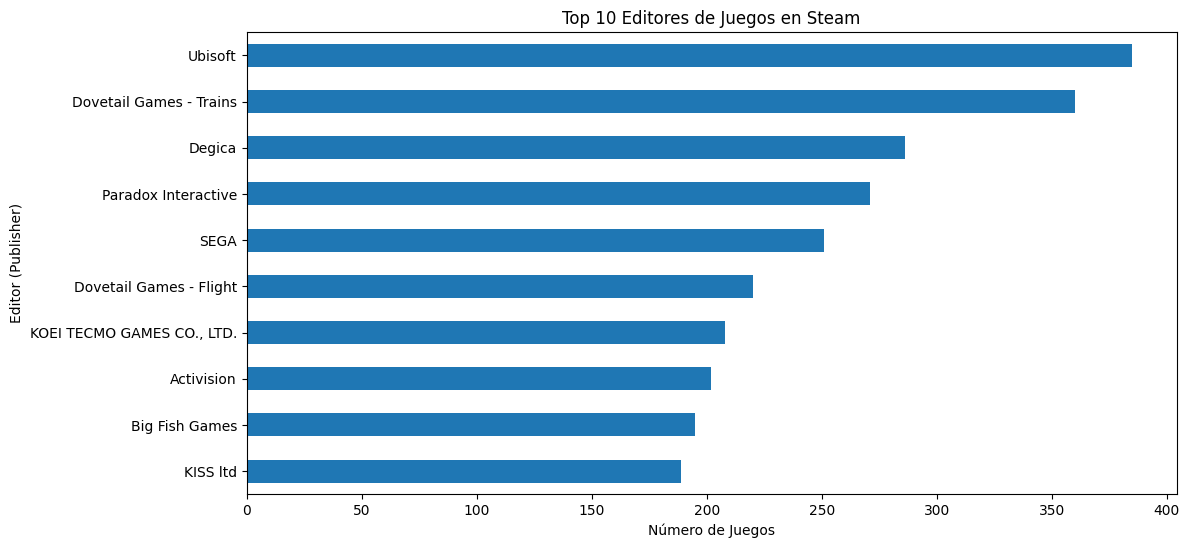

In [ ]:
import matplotlib.pyplot as plt

# Obtener los valores únicos y sus conteos
publisher_counts = steam_games['publisher'].value_counts()

# Crear un gráfico de barras descendente
plt.figure(figsize=(12, 6))  # Tamaño de la figura
publisher_counts.head(10).sort_values(ascending=False).plot(kind='barh')  # Mostrar los 10 principales, ordenados de forma descendente

# Configuración del gráfico
plt.xlabel('Número de Juegos')  # Etiqueta del eje X
plt.ylabel('Editor (Publisher)')  # Etiqueta del eje Y
plt.title('Top 10 Editores de Juegos en Steam')  # Título del gráfico
plt.gca().invert_yaxis()  # Invertir el eje Y para que los valores más altos estén arriba

# Mostrar el gráfico
plt.show()

In [ ]:
nulos =steam_games['publisher'].isnull()
steam_games[nulos]

,id,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,metascore,developer
4,773570,NaN,[],Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaT,"[Action, Indie, Casual, Sports]",http://steamcommunity.com/app/773570/reviews/?...,1.79,"[Single-player, Full controller support, HTC V...",2.99,0,<NA>,NaN
6,774276,NaN,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Basic Pass,SNOW - All Access Basic Pass,http://store.steampowered.com/app/774276/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]",http://steamcommunity.com/app/774276/reviews/?...,NaN,"[Single-player, Multi-player, Online Multi-Pla...",9.99,0,<NA>,Poppermost Productions
11,724910,NaN,[],Icarus Six Sixty Six,NaN,http://store.steampowered.com/app/724910/Icaru...,NaT,[Casual],http://steamcommunity.com/app/724910/reviews/?...,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...",0.00,0,<NA>,NaN
19,772590,NaN,[],After Life VR,NaN,http://store.steampowered.com/app/772590/After...,NaT,"[Early Access, Indie, VR]",http://steamcommunity.com/app/772590/reviews/?...,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...",4.99,1,<NA>,NaN
20,640250,NaN,[],Kitty Hawk,NaN,http://store.steampowered.com/app/640250/Kitty...,NaT,"[Early Access, Action, Adventure, Indie, Casual]",http://steamcommunity.com/app/640250/reviews/?...,1.97,"[Single-player, Steam Leaderboards, HTC Vive, ...",2.99,1,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32118,775640,NaN,[],Robotpencil Presents: Exercise: Brushwork,Robotpencil Presents: Exercise: Brushwork,http://store.steampowered.com/app/775640/Robot...,2018-01-03,"[Design & Illustration, Tutorial]",http://steamcommunity.com/app/775640/reviews/?...,NaN,[],3.99,0,<NA>,NaN
32119,777930,NaN,[],Robotpencil Presents: Creative Composition,Robotpencil Presents: Creative Composition,http://store.steampowered.com/app/777930/Robot...,2018-01-03,"[Design & Illustration, Tutorial]",http://steamcommunity.com/app/777930/reviews/?...,NaN,[],3.99,0,<NA>,NaN
32120,775370,NaN,[],The Gamble House,The Gamble House,http://store.steampowered.com/app/775370/The_G...,2016-11-19,[Movie],http://steamcommunity.com/app/775370/reviews/?...,NaN,[Captions available],4.99,0,<NA>,NaN
32121,777950,NaN,[],Kalen Chock Presents: 2017 Free Tutorial,Kalen Chock Presents: 2017 Free Tutorial,http://store.steampowered.com/app/777950/Kalen...,2018-01-03,"[Design & Illustration, Tutorial]",http://steamcommunity.com/app/777950/reviews/?...,NaN,[],0.00,0,<NA>,NaN


In [ ]:
steam_games = steam_games.drop(columns=['publisher', 'title', 'url', 'reviews_url', 'early_access'])

In [ ]:
nulos =steam_games['app_name'].isnull()
steam_games[nulos]

,id,genres,app_name,release_date,tags,discount_price,specs,price,metascore,developer
2580,317160,"[Action, Indie]",NaN,2014-08-26,"[Action, Indie]",NaN,"[Single-player, Game demo]",NaN,<NA>,NaN


In [ ]:
steam_games = steam_games.dropna(subset=['app_name'])

In [ ]:
steam_games = steam_games.reset_index(drop=True)

In [ ]:
type(steam_games['genres'][3213])

list

In [ ]:
len(steam_games[steam_games['genres'].apply(lambda x: len(x) == 0)])

3282

In [ ]:
len(steam_games[steam_games['tags'].apply(lambda x: len(x) == 0)])

162

In [ ]:
len(steam_games[steam_games['specs'].apply(lambda x: len(x) == 0)])

669

In [ ]:
# Función para unir y eliminar duplicados
def unir_y_eliminar_duplicados(row):
    # Utiliza conjuntos (sets) para eliminar duplicados y luego conviértelos nuevamente en una lista
    merged = list(set(row['genres'] + row['tags'] + row['specs']))
    return merged

# Aplica la función a cada fila para crear la columna 'especificaciones'
steam_games['especificaciones'] = steam_games.apply(unir_y_eliminar_duplicados, axis=1)

In [ ]:
len(steam_games[steam_games['especificaciones'].apply(lambda x: len(x) == 0)])

7

In [ ]:
steam_games = steam_games[steam_games['especificaciones'].apply(lambda x: len(x) > 0)]

In [ ]:
steam_games = steam_games.drop(columns=['tags', 'specs'])

In [ ]:
nulos = steam_games['metascore'].isnull()
len(steam_games[nulos])

29519

In [ ]:
steam_games = steam_games.drop(columns=['metascore'])

In [ ]:
nulos = steam_games['discount_price'].isnull()
len(steam_games[nulos])

31900

In [ ]:
steam_games['discount_price'] = steam_games['discount_price'].fillna(0)

In [ ]:
nulos = steam_games['price'].isnull()
df = steam_games[nulos]
valores_filtrados = [22.66, 49.96, 59.11, 35.97, 24.9, 17.08, 19.78, 2.05, 79.99, 49.99, 139.99, 24.82, 29.75, 22.46, 44.1]
# Filtrar el DataFrame para que los valores de 'discount_price' estén en la lista 'valores_filtrados'
df_filtrado = df[df['discount_price'].isin(valores_filtrados)]

In [ ]:
df_filtrado['discount_price'].unique()

array([ 22.66,  49.96,  59.11,  35.97,  24.9 ,  17.08,  19.78,   2.05,
        79.99,  49.99, 139.99,  24.82,  29.75,  22.46,  44.1 ])

In [ ]:
# Eliminar las filas donde 'price' es nulo y 'discount_price' esté en 'valores_a_verificar'
steam_games = steam_games.drop(steam_games[(steam_games['price'].isnull()) & (steam_games['discount_price'].isin(valores_filtrados))].index)

In [ ]:
nulos = steam_games['price'].isnull()
len(steam_games[nulos])

1307

In [ ]:
steam_games[nulos]

,id,genres,app_name,release_date,discount_price,price,developer,especificaciones
9,768800,"[Casual, Indie, Racing, Simulation]",Race,2018-01-04,0.0,NaN,RewindApp,"[Single-player, Racing, Indie, Multi-player, S..."
10,768570,"[Action, Indie, Simulation, Early Access]",Uncanny Islands,NaT,0.0,NaN,Qucheza,"[Single-player, Early Access, Indie, Survival,..."
31,520680,"[Casual, Indie, Strategy]",Lost Cities,2018-01-01,0.0,NaN,BlueLine Games,"[Turn-Based Strategy, Single-player, Strategy,..."
32,690410,[Action],Twisted Enhanced Edition,2018-01-01,0.0,NaN,Games by Brundle,"[Single-player, Platformer, Action, Full contr..."
34,413120,"[Action, Casual, Indie, Massively Multiplayer,...",Tactics Forever,2018-01-01,0.0,NaN,ProjectorGames,"[Strategy, Steam Turn Notifications, Indie, MM..."
...,...,...,...,...,...,...,...,...
32095,771070,"[Action, Indie]",Infinos Gaiden,2018-01-19,0.0,NaN,Picorinne Soft,"[Single-player, Indie, Action, Partial Control..."
32107,90007,[Sports],International Online Soccer,2002-01-01,0.0,NaN,I.O.S. Team,"[Multi-player, Mods (require HL2), Mod, Sports]"
32119,772180,"[Casual, Indie, Simulation, Sports, Early Access]",Cricket Club,2018-01-22,0.0,NaN,VersoVR,"[Single-player, Early Access, Indie, Simulatio..."
32121,771810,"[Action, Adventure, Indie]",The spy who shot me™,2018-10-01,0.0,NaN,Retro Army Limited,"[Single-player, Indie, Captions available, Act..."


In [ ]:
steam_games['price'] = steam_games['price'].fillna(0)

In [ ]:
# Contar la cantidad de valores nulos en todas las columnas
cantidad_nulos_por_columna = steam_games.isnull().sum()

# Mostrar la cantidad de nulos por columna
print(cantidad_nulos_por_columna)

id                     0
genres                 0
app_name               0
release_date        2170
discount_price         0
price                  0
developer           3290
especificaciones       0
dtype: int64


In [ ]:
steam_games[steam_games['especificaciones'].apply(lambda x: len(x) == 0)]

,id,genres,app_name,release_date,discount_price,price,developer,especificaciones


In [ ]:
nulos = steam_games['release_date'].isnull()
steam_games[nulos]

,id,genres,app_name,release_date,discount_price,price,developer,especificaciones
4,773570,[],Log Challenge,NaT,1.79,2.99,NaN,"[Oculus Rift, Single-player, Indie, HTC Vive, ..."
10,768570,"[Action, Indie, Simulation, Early Access]",Uncanny Islands,NaT,0.00,0.00,Qucheza,"[Single-player, Early Access, Indie, Survival,..."
11,724910,[],Icarus Six Sixty Six,NaT,0.00,0.00,NaN,"[Single-player, HTC Vive, Room-Scale, Tracked ..."
19,772590,[],After Life VR,NaT,0.00,4.99,NaN,"[Single-player, Early Access, Indie, HTC Vive,..."
20,640250,[],Kitty Hawk,NaT,1.97,2.99,NaN,"[Single-player, Early Access, Indie, HTC Vive,..."
...,...,...,...,...,...,...,...,...
32080,729640,"[Action, Casual, Indie]",BOMBFEST,NaT,0.00,0.00,The BOMBFEST Team,"[Single-player, Indie, Local Multi-Player, Mul..."
32081,755540,[],LIV Client,NaT,0.00,0.00,NaN,"[Keyboard / Mouse, Oculus Rift, Utilities, Sea..."
32083,755830,"[Action, Casual, Indie, Simulation]",Lonely Astronaut,NaT,0.00,0.00,"Greyson Richey,Nicholas Lives","[Single-player, Indie, Simulation, Action, Cas..."
32084,708070,"[Action, Adventure, Indie, Early Access]",RECHARGE COMPLETE,NaT,0.00,0.00,rechargecomplete,"[Single-player, Early Access, Indie, Steam Ach..."


In [ ]:
steam_games = steam_games.reset_index(drop=True)

In [ ]:
steam_games

,id,genres,app_name,release_date,discount_price,price,developer,especificaciones
0,761140,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,4.49,4.99,Kotoshiro,"[Single-player, Strategy, Indie, Simulation, A..."
1,643980,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,0.00,0.00,Secret Level SRL,"[Indie, Trading Card Game, In-App Purchases, S..."
2,670290,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,0.00,0.00,Poolians.com,"[Free to Play, Single-player, Indie, Multi-pla..."
3,767400,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,0.83,0.99,彼岸领域,"[Single-player, Casual, Adventure, Action]"
4,773570,[],Log Challenge,NaT,1.79,2.99,NaN,"[Oculus Rift, Single-player, Indie, HTC Vive, ..."
...,...,...,...,...,...,...,...,...
32054,773640,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,2018-01-04,1.49,1.99,"Nikita ""Ghost_RUS""","[Single-player, Strategy, Indie, Steam Achieve..."
32055,733530,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,2018-01-04,4.24,4.99,Sacada,"[Single-player, Strategy, Indie, Steam Achieve..."
32056,610660,"[Indie, Racing, Simulation]",Russian Roads,2018-01-04,1.39,1.99,Laush Dmitriy Sergeevich,"[Single-player, Racing, Indie, Steam Achieveme..."
32057,658870,"[Casual, Indie]",EXIT 2 - Directions,2017-09-02,0.00,4.99,"xropi,stev3ns","[Single-player, Indie, Puzzle, Steam Achieveme..."


In [ ]:
steam_games.to_parquet('/content/drive/My Drive/DataOutput_mvp_steam/steam_games.parquet')